# 👋 Welcome to the tutorial

In this tutorial, we will see how the proposed `SMDL-Attribution` method works on ViT-based backbone. Models and attribution code will be entirely based on `PyTorch`.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.chdir("../")

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

plt.style.use('seaborn')

from utils import *
import matplotlib

matplotlib.get_cachedir()
plt.rc('font', family="Times New Roman")
from sklearn import metrics

import torch
from torchvision import transforms

/tmp/ipykernel_1004539/306386441.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

### 🛠️ Models and preprocessing function setup
Since multi-modal models, such as CLIP, have dual-stream input, we need its image encoder. The input is an image `[B, C, W, H]` in torch format, and the output is a d-dimensional vector `[B, d]`. So please convert the model, let's take `ImageBind` as an example:

In [3]:
# https://github.com/facebookresearch/ImageBind
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [4]:
class ImageBindModel_Super(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, vision_inputs):
        """
        Input:
            vision_inputs: torch.size([B,C,W,H])
        Output:
            embeddings: a d-dimensional vector torch.size([B,d])
        """
        inputs = {
            "vision": vision_inputs,
        }
        
        with torch.no_grad():
            embeddings = self.base_model(inputs)
        
        return embeddings["vision"]

You also need to prepare a preprocessing function, the input is an image format read by `OpenCV` (Image channel order is BGR), and the output is the preprocessed Tensor, as follows:

In [5]:
def transform_vision_data(image):
    """
    Input:
        image: An image read by opencv [w,h,c]
    Output:
        image: After preproccessing, is a tensor [c,w,h]
    """
    data_transform = transforms.Compose(
        [
            transforms.Resize(
                (224,224), interpolation=transforms.InterpolationMode.BICUBIC
            ),
            # transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073),
                std=(0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )
    
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image = data_transform(image)
    return image

Let's have a try

In [6]:
image_path = "examples/dog_image.jpg"
image = cv2.imread(image_path)
image = transform_vision_data(image)
print(image.shape)

torch.Size([3, 224, 224])


In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

vis_model = ImageBindModel_Super(model)
print("load imagebind model")

load imagebind model


In [17]:
vis_model.base_model.modality_trunks.vision.blocks[-1].norm_1

LayerNorm((1280,), eps=1e-06, elementwise_affine=True)

In [8]:
vis_feature = vis_model(image.unsqueeze(0).to(device))
print("The output size of the visual feature is {}.".format(vis_feature.shape))

The output size of the visual feature is torch.Size([1, 1024]).


### ✏️ Image Division

For example, you can use SLICO to segment the image, as shown below:

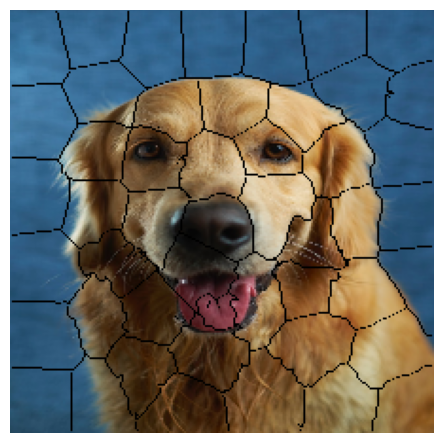

In [9]:
image_path = "examples/dog_image.jpg"
img = cv2.imread(image_path)
img = cv2.resize(img, (224,224))
slic = cv2.ximgproc.createSuperpixelSLIC(img, region_size=30, ruler = 20.0) 
slic.iterate(20)     #迭代次数，越大效果越好
mask_slic = slic.getLabelContourMask() #获取Mask，超像素边缘Mask==1
label_slic = slic.getLabels()        #获取超像素标签
number_slic = slic.getNumberOfSuperpixels()  #获取超像素数目
mask_inv_slic = cv2.bitwise_not(mask_slic)
img_slic = cv2.bitwise_and(img, img, mask =  mask_inv_slic) #在原图上绘制超像素边界

imshow(img_slic)

You can simplify the process using libraries like below:

In [10]:
image_path = "examples/dog_image.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
element_sets_V = SubRegionDivision(image, mode="slico")

### 🔥 Attribution

In [11]:
from models.submodular_vit_torch import MultiModalSubModularExplanation

In [12]:
text_list=[
    "A dog.", "A car.", "A bird.", "An airplane.", "A bicycle.", 
    "A boat.", "A cat.", "A chair", "A cow.", "A diningtable.", 
    "A horse.", "A motorbike.", "A person.", "A pottedplant.", "A sheep.", 
    "A sofa.", "A train.", "A tvmonitor."]
text_modal_input = data.load_and_transform_text(text_list, device)
input = {
    "text": text_modal_input
}
with torch.no_grad():
    semantic_feature = model(input)["text"]

explainer = MultiModalSubModularExplanation(
    vis_model, semantic_feature, transform_vision_data, device=device, lambda1 = 0, lambda2 = 0.1, lambda4=5)

In [13]:
explainer.k = len(element_sets_V)
submodular_image, submodular_image_set, saved_json_file = explainer(element_sets_V, id=0)

100%|██████████| 49/49 [00:59<00:00,  1.22s/it]


### 😮 Visualization

In [14]:
def visualization(image, submodular_image_set, saved_json_file, index=None):
    insertion_ours_images = []
    deletion_ours_images = []

    insertion_image = submodular_image_set[0]
    insertion_ours_images.append(insertion_image)
    deletion_ours_images.append(image - insertion_image)
    for smdl_sub_mask in submodular_image_set[1:]:
        insertion_image = insertion_image.copy() + smdl_sub_mask
        insertion_ours_images.append(insertion_image)
        deletion_ours_images.append(image - insertion_image)

    insertion_ours_images_input_results = np.array(saved_json_file["consistency_score"])

    if index == None:
        ours_best_index = np.argmax(insertion_ours_images_input_results)
    else:
        ours_best_index = index
    x = [(insertion_ours_image.sum(-1)!=0).sum() / (image.shape[0] * image.shape[1]) for insertion_ours_image in insertion_ours_images]
    i = len(x)

    fig, [ax2, ax3] = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1, 1.5]}, figsize=(24,8))
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax2.set_title('Ours', fontsize=54)
    ax2.set_facecolor('white')

    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    plt.title('Insertion', fontsize=54)
    plt.ylabel('Recognition Score', fontsize=44)
    plt.xlabel('Percentage of image revealed', fontsize=44)

    x_ = x[:i]
    ours_y = insertion_ours_images_input_results[:i]
    ax3.plot(x_, ours_y, color='dodgerblue', linewidth=3.5)  # draw curve

    # plt.legend(["Ours"], fontsize=40, loc="upper left")
    plt.scatter(x_[-1], ours_y[-1], color='dodgerblue', s=54)  # Plot latest point

    kernel = np.ones((3, 3), dtype=np.uint8)
    plt.plot([x_[ours_best_index], x_[ours_best_index]], [0, 1], color='red', linewidth=3.5)  # 绘制红色曲线

    # Ours
    mask = (image - insertion_ours_images[ours_best_index]).mean(-1)
    mask[mask>0] = 1

    dilate = cv2.dilate(mask, kernel, 3)
    # erosion = cv2.erode(dilate, kernel, iterations=3)
    # dilate = cv2.dilate(erosion, kernel, 2)
    edge = dilate - mask
    # erosion = cv2.erode(dilate, kernel, iterations=1)

    image_debug = image.copy()

    image_debug[mask>0] = image_debug[mask>0] * 0.5
    image_debug[edge>0] = np.array([0,0,255])
    ax2.imshow(image_debug[...,::-1])

    auc = metrics.auc(x, insertion_ours_images_input_results)

    print("Highest confidence: {}\nfinal confidence: {}\nInsertion AUC: {}".format(insertion_ours_images_input_results.max(), insertion_ours_images_input_results[-1], auc))

Highest confidence: 0.9972473978996277
final confidence: 0.9972473978996277
Insertion AUC: 0.9571406953844566
Highest confidence: 0.9972473978996277
final confidence: 0.9972473978996277
Insertion AUC: 0.9571406953844566


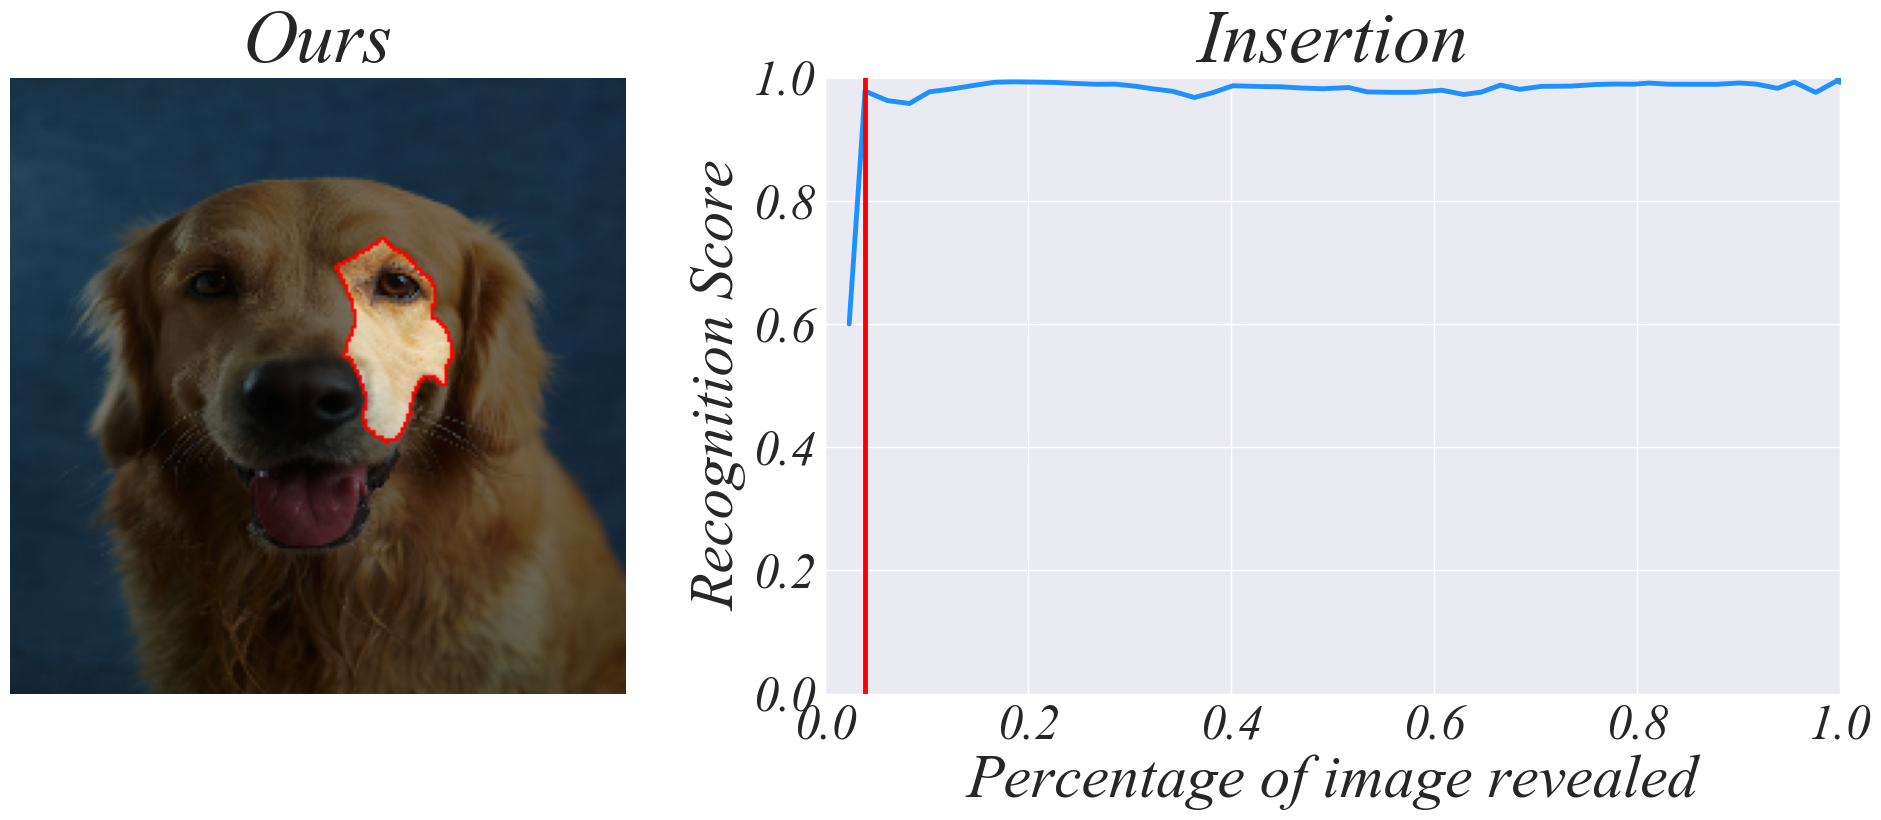

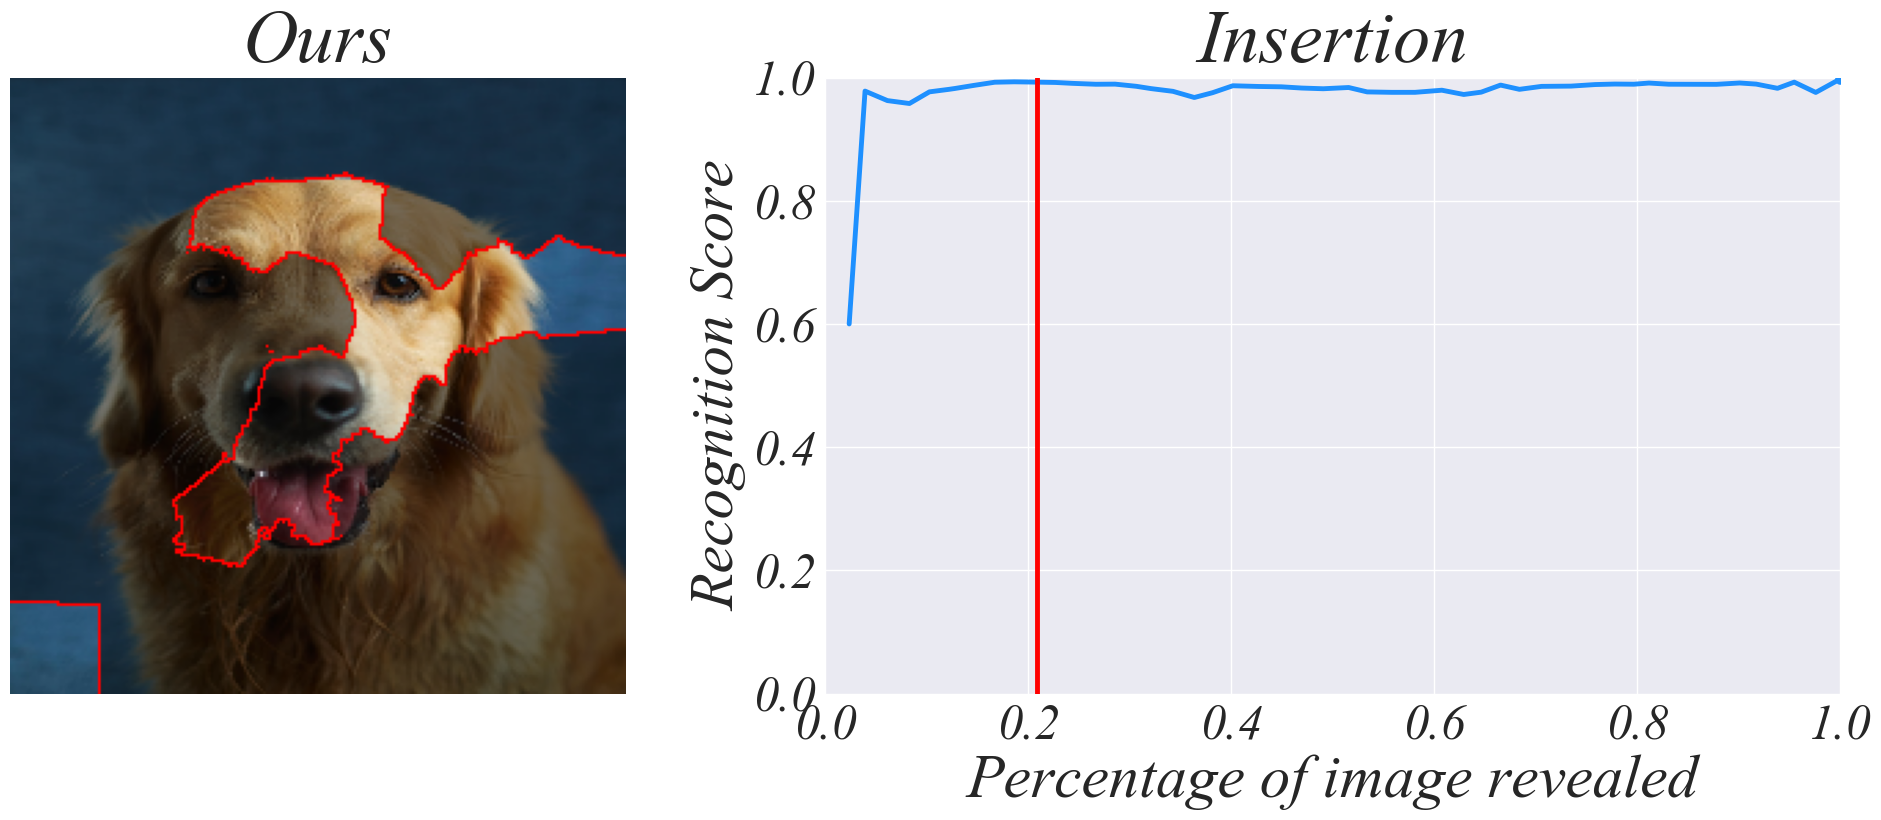

In [15]:
# change index to visualize limited region
visualization(image, submodular_image_set, saved_json_file, index=1)

visualization(image, submodular_image_set, saved_json_file, index=10)